In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords

In [3]:
df = pd.read_csv('datasets/Tweets.csv')

In [4]:
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [5]:
from sklearn.preprocessing import LabelEncoder

## 1. Preprocessing Data

### Convert label into numeric: 0 -> neutral, 1 -> positive, 2 -> negative

In [6]:
encoder = LabelEncoder()
df['sentiment'] = encoder.fit_transform(df['airline_sentiment'])


In [7]:
from nltk.stem import PorterStemmer

stop_words = set(stopwords.words('english'))

def remove_stop_words(text):
   words = text.split()
   ret = []
   for word in words:
    if not word in stop_words:
        ret.append(word)
   return (' '.join(ret))

def remove_stem_words(text):
    stemmer = PorterStemmer()
    ret = []
    words = text.split()
    for word in words:
        ret.append(stemmer.stem(word))
    return ' '.join(ret)



In [8]:
#test remove_stem_word function
remove_stem_words("testing tested test python programming")

'test test test python program'

In [9]:
#replace special letter by space
df['clean_text'] = df['text'].apply(lambda x : re.sub('[^A-Za-z0-9]', ' ', x))

#lower case 
df['clean_text'] = df['clean_text'].apply(lambda x : x.lower())

#replace multiple spaces by one space
df['clean_text'] = df['clean_text'].apply(lambda x : re.sub(r'\s+',' ',x))

#replace leading & trailing space by ''
df['clean_text'] = df['clean_text'].apply(lambda x : re.sub(r'\s+|\s+?$',' ',x))

#replace texts starting with @
df['clean_text'] = df['clean_text'].apply(lambda x : re.sub(r'@[A-Za-z0-9]+',' ',x))
                                          
#remove url starting with http://
df['clean_text'] = df['clean_text'].apply(lambda x : re.sub('https?://[A-Za-z0-9./]+',' ',x))
                                          
# remove stop words that dont contibute to the accurate prediction of model
df['clean_text'] = df['clean_text'].apply(lambda x : remove_stop_words(x))

# remove morphological affixes from words, leaving only the word stem
df['clean_text'] = df['clean_text'].apply(lambda x : remove_stem_words(x))


print (df['clean_text'][:5])





0                          virginamerica dhepburn said
1           virginamerica plu ad commerci experi tacki
2    virginamerica today must mean need take anoth ...
3    virginamerica realli aggress blast obnoxi ente...
4                   virginamerica realli big bad thing
Name: clean_text, dtype: object


## 2. Exploratory Data Analysis

In [10]:
df['negativereason'].value_counts()

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64

In [11]:
df1 = df[['airline', 'negativereason']]

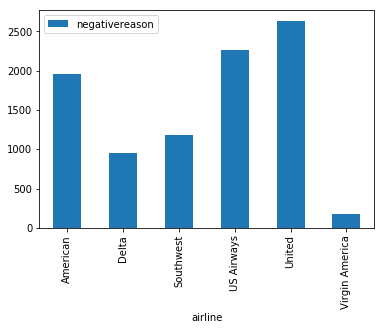

In [12]:
df1.groupby('airline').count().plot(kind='bar')

#### It seems Virgine Ameria offers the best service meanwhile United arline got complained the most.Let's plot negative reason for each airline

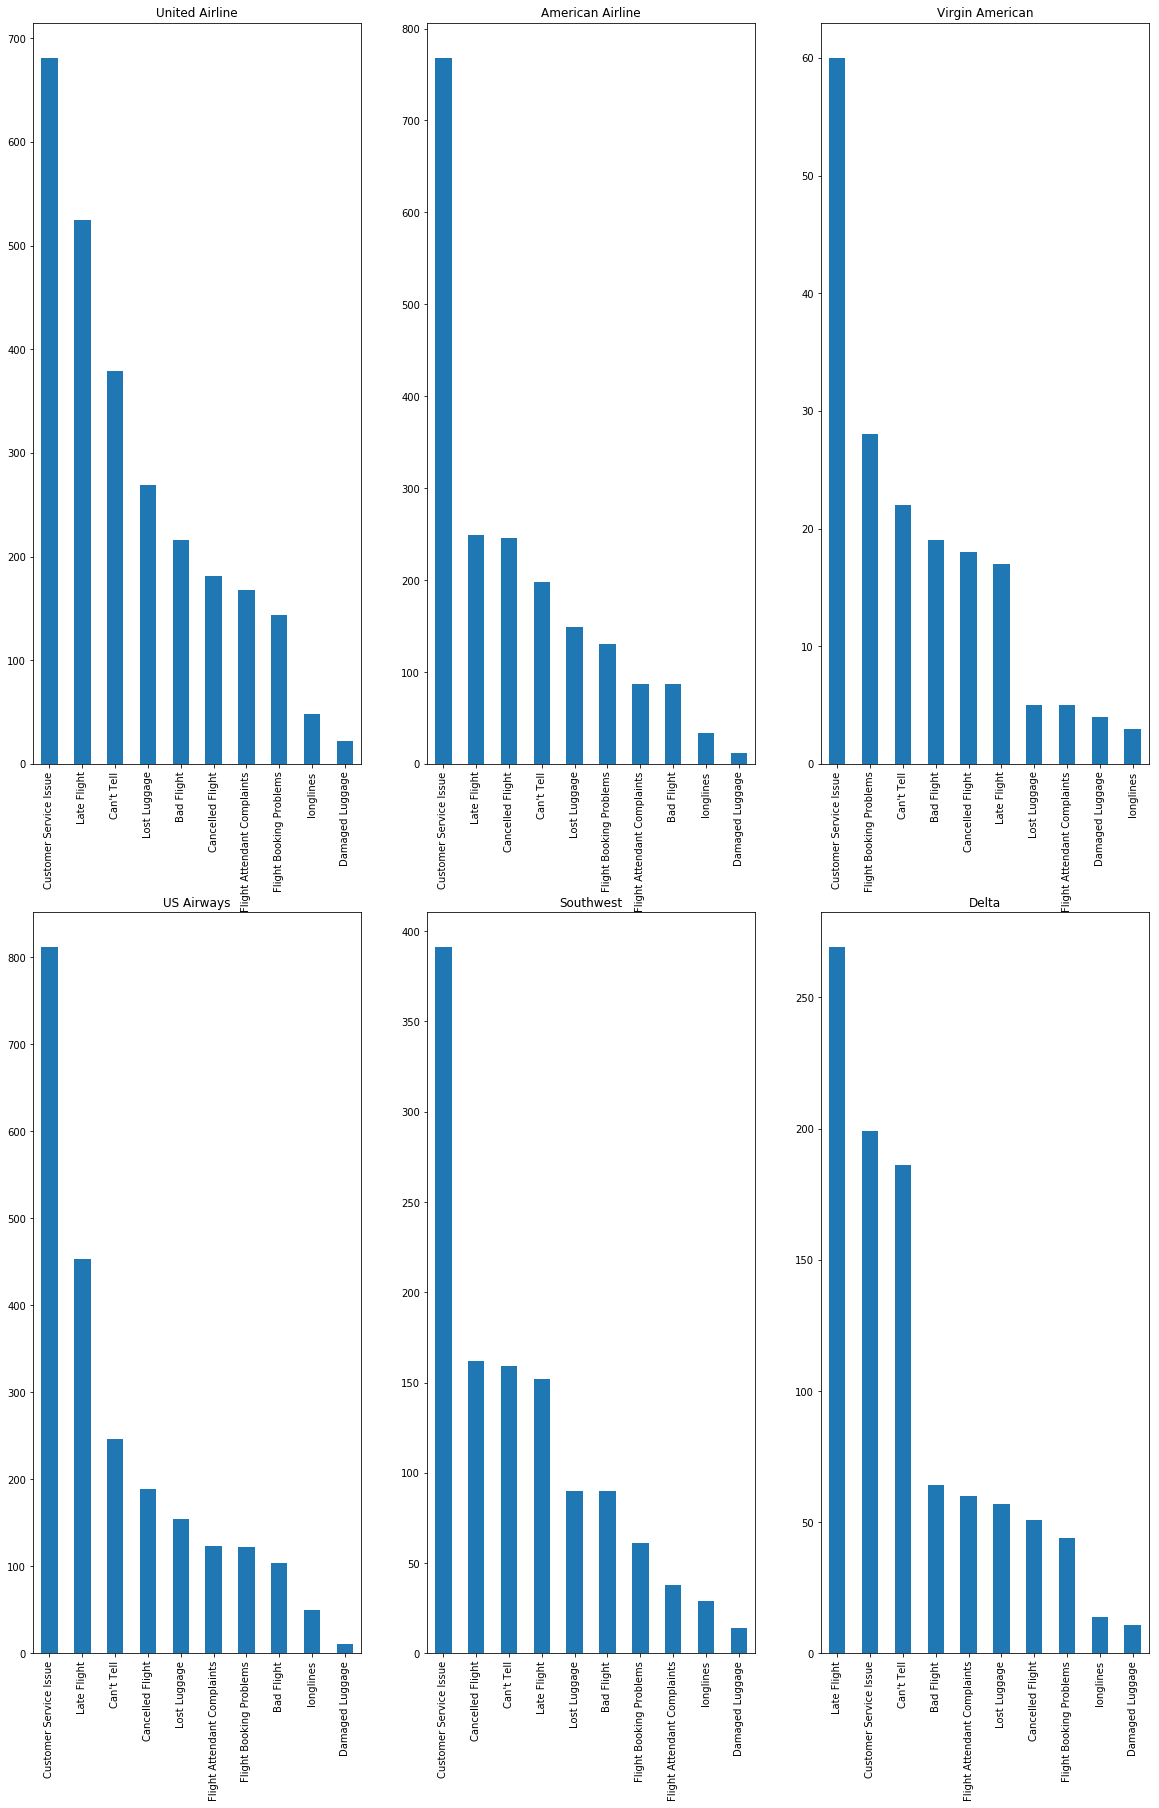

In [13]:
plt.figure(1,figsize=(20, 30))

plt.subplot(231)
df[df['airline'] == 'United']['negativereason'].value_counts().plot(kind='bar', title='United Airline')

plt.subplot(232)
df[df['airline'] == 'American']['negativereason'].value_counts().plot(kind='bar', title='American Airline')

plt.subplot(233)
df[df['airline'] == 'Virgin America']['negativereason'].value_counts().plot(kind='bar', title='Virgin American')

plt.subplot(234)
df[df['airline'] == 'US Airways']['negativereason'].value_counts().plot(kind='bar', title='US Airways')

plt.subplot(235)
df[df['airline'] == 'Southwest']['negativereason'].value_counts().plot(kind='bar', title='Southwest')

plt.subplot(236)
df[df['airline'] == 'Delta']['negativereason'].value_counts().plot(kind='bar', title='Delta')


plt.show()

#### The result shows that Customer Service Issue, late flights and canclled flights caused the negative reason

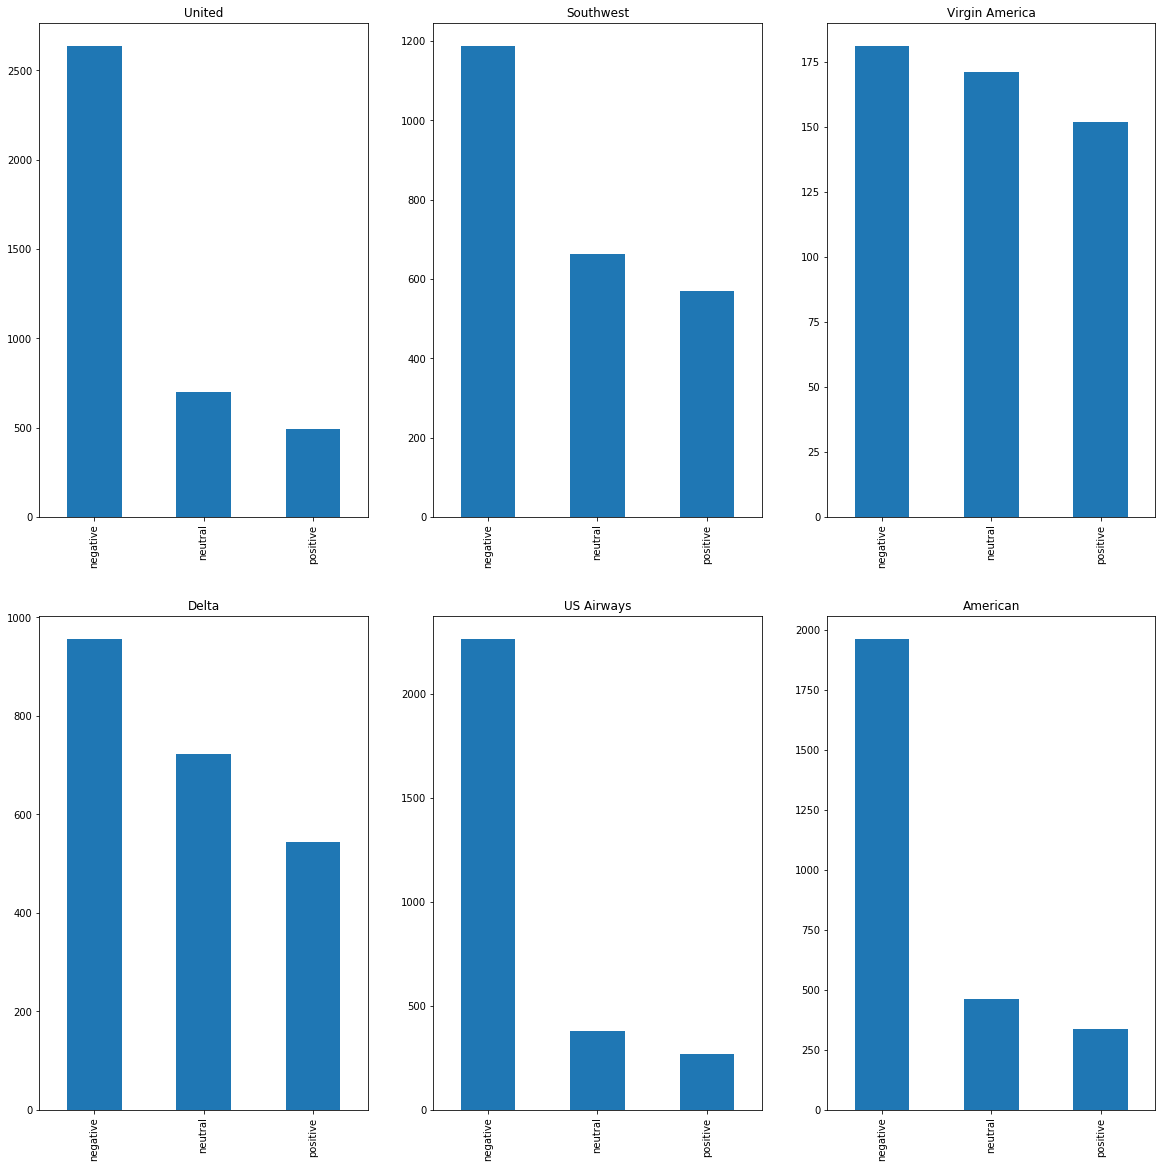

In [14]:
#a figure with witdth=20 and height=10
plt.figure(1,figsize=(20, 20))

plt.subplot(231)
df[df['airline'] == 'United']['airline_sentiment'].value_counts().plot(kind='bar',title='United')

plt.subplot(232)
df[df['airline'] == 'Southwest']['airline_sentiment'].value_counts().plot(kind='bar',title='Southwest')

plt.subplot(233)
df[df['airline'] == 'Virgin America']['airline_sentiment'].value_counts().plot(kind='bar',title='Virgin America')

plt.subplot(234)
df[df['airline'] == 'Delta']['airline_sentiment'].value_counts().plot(kind='bar',title='Delta')

plt.subplot(235)
df[df['airline'] == 'US Airways']['airline_sentiment'].value_counts().plot(kind='bar',title='US Airways')

plt.subplot(236)
df[df['airline'] == 'American']['airline_sentiment'].value_counts().plot(kind='bar',title='American')

plt.show()

#### As we see that Amercian airline got the most negative feedbacks and the less positive feedbacks

#### WordCloud for the most frequent words in negative tweets

In [15]:
from wordcloud import WordCloud,STOPWORDS

(-0.5, 399.5, 199.5, -0.5)

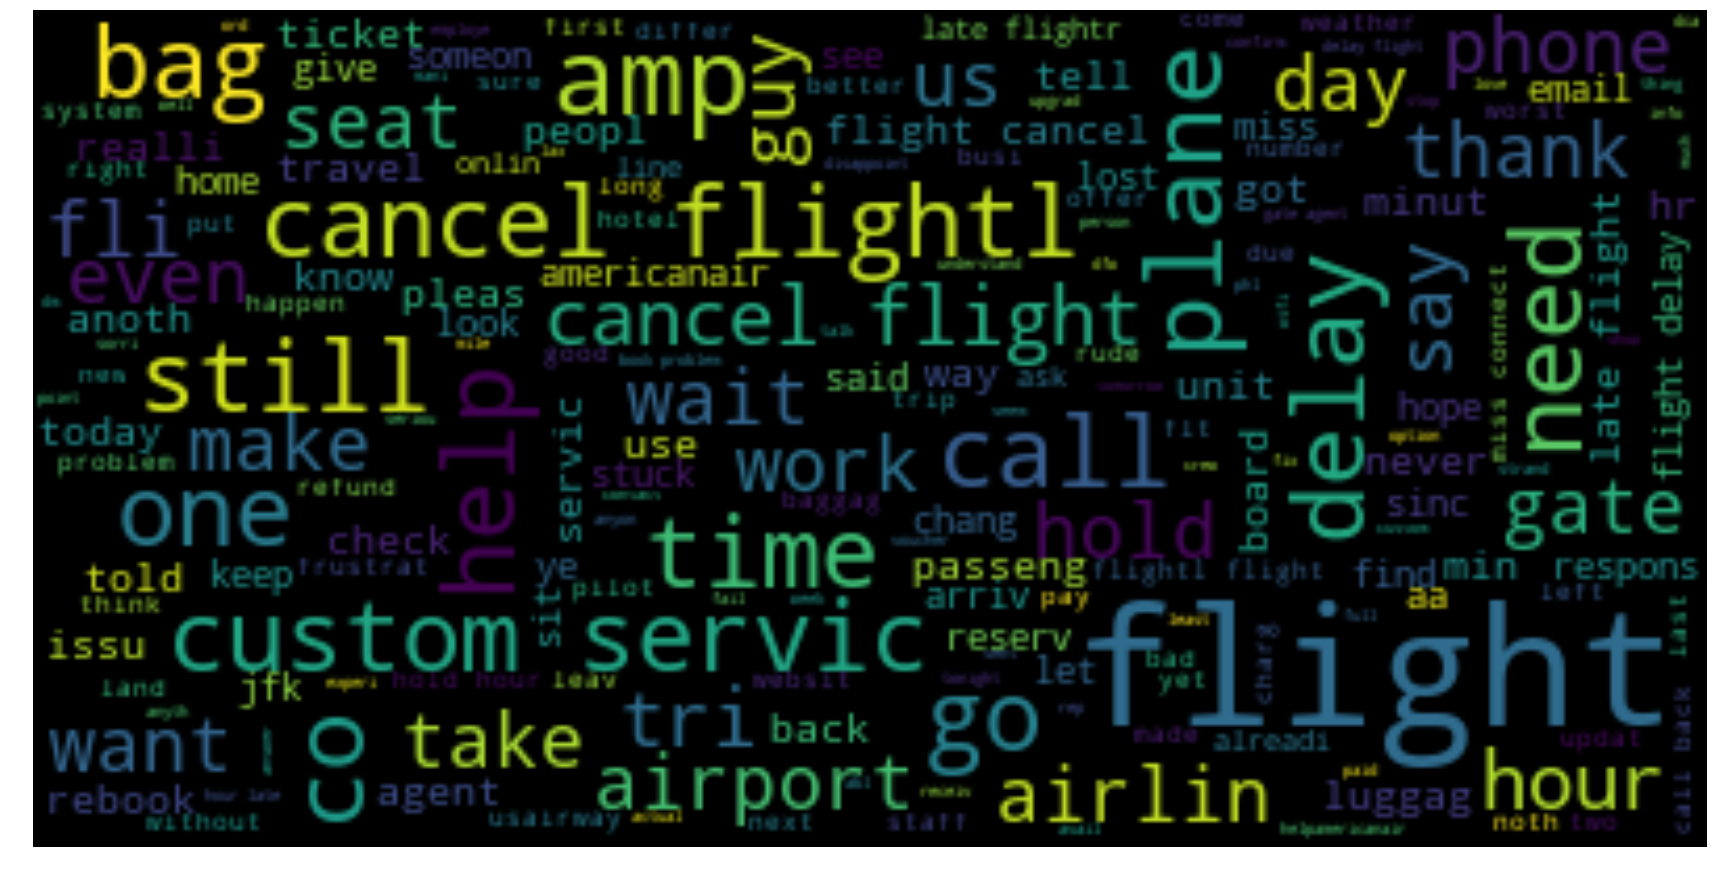

In [16]:
negative_tweets = ''.join(df[df['sentiment'] == 0]['clean_text'])
wordcloud = WordCloud(max_font_size=40).generate(negative_tweets)
plt.figure(1, figsize=(30,30))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

#### Wordcloud for the most frequent words in neutral tweets

(-0.5, 399.5, 199.5, -0.5)

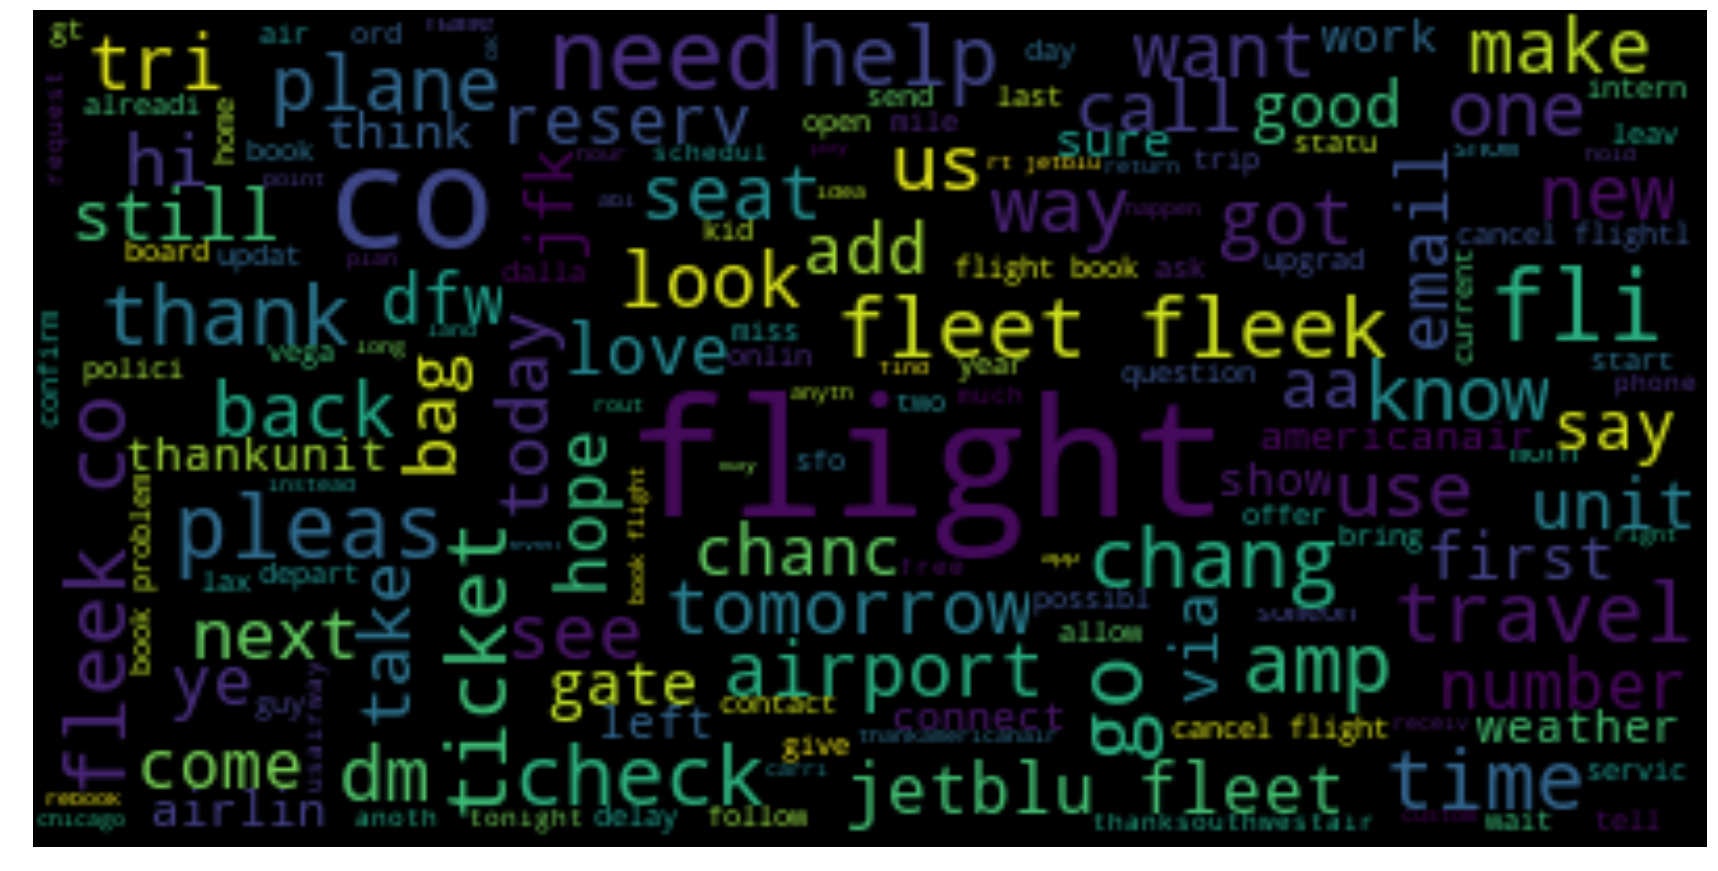

In [17]:
neutral_tweets = ''.join(df[df['sentiment'] == 1]['clean_text'])
wordcloud = WordCloud(max_font_size=40).generate(neutral_tweets)
plt.figure(1, figsize=(30,30))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

#### Wordcloud for most frequent words in positive tweets

(-0.5, 399.5, 199.5, -0.5)

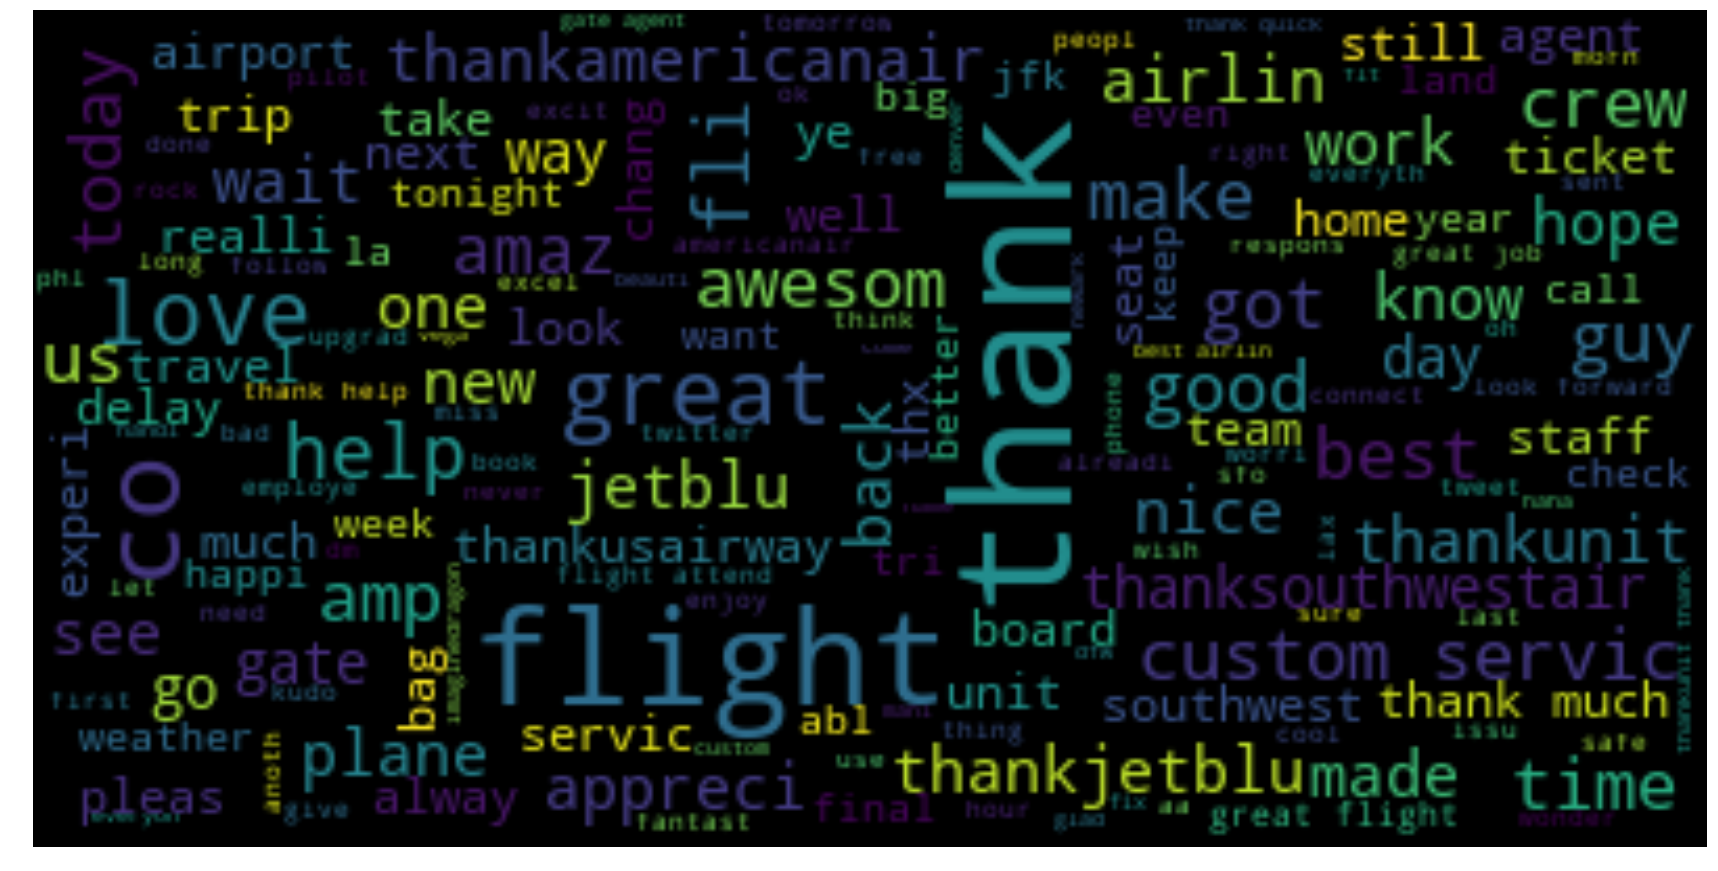

In [18]:
positive_tweets = ''.join(df[df['sentiment'] == 2]['clean_text'])
wordcloud = WordCloud(max_font_size=40).generate(positive_tweets)
plt.figure(1, figsize=(30,30))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

## 3. Build Machine Learning Model

In [19]:
#Convert a collection of text documents to a matrix of token counts
from sklearn.feature_extraction.text import CountVectorizer
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\btdiem\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [30]:
vectorizer = CountVectorizer(analyzer = "word")
vectorizer.fit(df['clean_text'])
X = vectorizer.transform(df['clean_text'])
print(type(X))

<class 'scipy.sparse.csr.csr_matrix'>


In [94]:
#print(X.toarray())
print(df['sentiment'].values)

[1 2 1 ... 1 0 1]


In [31]:
message0 = df['clean_text'][:1]
print(message0)

0    virginamerica dhepburn said
Name: clean_text, dtype: object


In [38]:
mtx0 = vectorizer.transform(message0)


In [35]:
print(mtx0)

  (0, 5686)	1


In [72]:
print(vectorizer.get_feature_names()[4038])
print(vectorizer.get_feature_names()[9456])
print(vectorizer.get_feature_names()[11555])

dhepburn
said
virginamerica


In [73]:
mtx0 = vectorizer.transform(["there is an issue with the flight"])

In [74]:
print(mtx0)


  (0, 2106)	1
  (0, 4956)	1
  (0, 10610)	1


In [76]:
print(vectorizer.get_feature_names()[2106])
print(vectorizer.get_feature_names()[4956])
print(vectorizer.get_feature_names()[10610])
print(df['sentiment'][2106])
print(df['sentiment'][4956]) 
print(df['sentiment'][10610]) 

an
flight
there
0
1
0


In [95]:
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split


In [96]:
text_train, text_test, label_train, label_test = train_test_split(X.toarray(), df['sentiment'].values,test_size=0.3)

# Random Forest Classifier Accuracy : 0.73
# Multinominal Accuracy : 0.75
# Logistic Regression Accuracy : 0.78


In [97]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.svm import SVC


models = {
    
    "Random Forest Classifier" : RandomForestClassifier(),
    "Multinominal" : MultinomialNB(),
    "Logistic Regression" : LogisticRegression(),
    "KNeighbor Classifier" : KNeighborsClassifier(),
    "SVC" : SVC(kernel='linear')
}

for i, (model_name, model) in enumerate(models.items()):
    model.fit(text_train, label_train)
    pred = model.predict(text_test)
    print('Model: {} Accuracy : {:.2f}'.format(model_name,model.score(text_test, label_test)))
    print(classification_report(y_true=label_test,y_pred=pred))
   




C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Model: Random Forest Classifier Accuracy : 0.73
              precision    recall  f1-score   support

           0       0.77      0.90      0.83      2712
           1       0.55      0.40      0.46       949
           2       0.74      0.54      0.63       731

   micro avg       0.73      0.73      0.73      4392
   macro avg       0.69      0.61      0.64      4392
weighted avg       0.72      0.73      0.72      4392

Model: Multinominal Accuracy : 0.75
              precision    recall  f1-score   support

           0       0.76      0.94      0.84      2712
           1       0.66      0.39      0.49       949
           2       0.78      0.48      0.60       731

   micro avg       0.75      0.75      0.75      4392
   macro avg       0.73      0.60      0.64      4392
weighted avg       0.74      0.75      0.72      4392



C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Model: Logistic Regression Accuracy : 0.78
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      2712
           1       0.63      0.53      0.58       949
           2       0.75      0.65      0.69       731

   micro avg       0.78      0.78      0.78      4392
   macro avg       0.73      0.69      0.71      4392
weighted avg       0.77      0.78      0.77      4392

Model: KNeighbor Classifier Accuracy : 0.61
              precision    recall  f1-score   support

           0       0.77      0.69      0.73      2712
           1       0.34      0.43      0.38       949
           2       0.53      0.57      0.55       731

   micro avg       0.61      0.61      0.61      4392
   macro avg       0.55      0.56      0.55      4392
weighted avg       0.64      0.61      0.62      4392

Model: SVC Accuracy : 0.76
              precision    recall  f1-score   support

           0       0.83      0.86      0.84      2712
           1   